# Auditing for Data Quality - Analyze for Integrity Constraints

## Load Data

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
!pip install --upgrade -q gspread

from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

In [ ]:
def get_df(file_name, location):
  worksheet = gc.open('Sales').get_worksheet(location)
  rows = worksheet.get_all_values()
  head = rows[0]
  data = rows[1:]
  df = pd.DataFrame.from_records(data, columns=head)
  return df

In [334]:
employees = get_df('Sales', 0)
display(employees)

,Employee ID,First Name,Last Name,Department,City
0,10001,Daniel,Olson,Electronics,San Francisco
1,10002,Nick,Markmen,Clothes,San Francisco
2,10003,Maria,Gonzales,Electronics,San Jose
3,10004,George,Wong,Clothes,San Francisco
4,10005,Stephanie,Williams,Clothes,Oakland
5,10006,Miguel,Alva,Clothes,Oakland
6,10007,Jessica,Collins,Cosmetics,San Francisco
7,10008,Ted,Anderson,Clothes,Oakland
8,10009,Victoria,Garcia,Clothes,San Jose
9,10010,Jasmine,Khan,"Pharmacy, Health & Beauty",Oakland


In [ ]:
customers = get_df('Sales', 1)
display(customers)

In [ ]:
products = get_df('Sales', 2)
display(products)

In [ ]:
orders = get_df('Sales', 3)
display(orders)

In [ ]:
suppliers = get_df('Sales', 4)
display(suppliers)

## Auditing Data

In [ ]:
employees.describe()

**Number of Departments**

In [ ]:
employees.groupby('Department')['Department'].count()

**Number of cities across all tables**

In [ ]:
employees.groupby('City')['City'].count()

In [ ]:
cities = pd.concat([employees, customers])
cities = pd.concat([cities, suppliers])
cities.groupby('City')['City'].count()

**Filter records by missing fields**

In [ ]:
def missing_fields(df, field):
  missing_data = df[(df[field] == '') | (df[field] == 'N\A') | (df[field] == None) | (df[field] == ' ')]
  return missing_data

In [ ]:
display(missing_fields(employees, 'Last Name'))
display(missing_fields(customers, 'Last Name'))

**Filter records by incorrect length**

In [ ]:
def incorrect_length(df, field, length):
  incorrect_length = df[df[field].str.len() != length]
  return incorrect_length

In [ ]:
display(incorrect_length(employees, 'Employee ID', 5))
display(incorrect_length(products, 'Product ID', 5))

**Filter records if they do not conform to numerical ids**

In [ ]:
def check_ids_num(df, field):
  non_numbers = df[~df[field].str.contains(r"^[0-9]*$")]
  return non_numbers

In [ ]:
display(check_ids_num(employees, 'Employee ID'))
display(check_ids_num(products, 'Product ID'))

**Filter records that don't match the length or starting number format**

In [ ]:
def consistent_ids(df, field, starting_number):
  rex = r"" + str(starting_number) + "[0-9]{4}$"
  inconsistent_numbers = df[~df[field].str.contains(rex)]
  return inconsistent_numbers

In [ ]:
display(consistent_ids(employees, 'Employee ID', '1'))
display(consistent_ids(products, 'Product ID', '3'))

**Filter records if the names don't have the first letter capitolized followed by a series of non-capitolized**

In [ ]:
def verify_name_format(df, field):
  # Check if name does not have letters as first or last character in the field
  unusual_name_format = df[~df[field].str.contains(r"^[A-Z][a-z]*$")]
  return unusual_name_format

In [ ]:
display(verify_name_format(employees, 'First Name'))
display(verify_name_format(employees, 'Last Name'))

**Filter records that are not listed in a given list**

In [ ]:
def cross_reference_entries(df, field, standard_list):
  unknown_entries = df[~(df[field].isin(standard_list))]
  return unknown_entries

In [ ]:
cities = ['San Francisco', 'Oakland', 'San Jose', 'Berkeley', 'New York', 'Mexico']
display(cross_reference_entries(employees, 'City', cities))

**Filter price records that are not in numerical string format**



In [ ]:
def verify_numerical_prices(df, field):
  non_numerical_prices = df[(~df[field].str.contains(r"[0-9]"))]
  return non_numerical_prices

In [ ]:
display(verify_numerical_prices(products, 'Price'))

**Filter records that are out of range**

In [ ]:
def verify_date_range(df, field, start_date, end_date):
  incorrect_dates = df[(df[field] < start_date) | (df[field] > end_date)]
  return incorrect_dates

In [ ]:
display(verify_date_range(orders, 'Date', '17-01-01', '18-01-01'))

**Audit IDs by combining several functions**

In [ ]:
def audit_ids(df, field, starting_number):
  results = pd.DataFrame({})
  
  # Check if missing field
  missing_data = missing_fields(df, field)
  results = pd.concat([results, missing_data])
  
  # Check the id lenght is of the proper lenght
  incorrect_lengths = incorrect_length(df, field, 5)
  results = pd.concat([results, incorrect_lengths]).drop_duplicates().reset_index(drop=True)
  
  # Check if all ids are numbers
  non_numbers = check_ids_num(df, field)
  results = pd.concat([results, non_numbers]).drop_duplicates().reset_index(drop=True)
  
  # Check if numbers have a consistent match
  inconsistent_numbers = consistent_ids(df, field, starting_number)
  results = pd.concat([results, inconsistent_numbers]).drop_duplicates().reset_index(drop=True)
  return results
  

In [ ]:
display(audit_ids(employees, 'Employee ID', '1'))
# Doesn't catch missing records
display(audit_ids(customers, 'Customer ID', '2'))
display(audit_ids(products, 'Product ID', '3'))
display(audit_ids(products, 'Supplier ID', '4'))
display(audit_ids(orders, 'Order ID', '5'))
display(audit_ids(orders, 'Customer ID', '2'))
display(audit_ids(suppliers, 'Supplier ID', '4'))

**Audit cities by combining several filtering methods**

In [ ]:
def audit_cities(df, field):
  results = pd.DataFrame({})
  
  # Check if missing field
  missing_data = missing_fields(df, field)
  results = pd.concat([results, missing_data])
  
  # Check if name does not have first or last character in the field
  unusual_name_format = df[(~df[field].str.contains(r"^([A-Z][a-z]*\s{0,1})*[a-z]$"))]
  results = pd.concat([results, unusual_name_format]).drop_duplicates().reset_index(drop=True)
  
  # Check if name matches out list of know cities
  known_cities = ['San Francisco', 'Oakland', 'San Jose', 'Berkeley', 'Palo Alto', 'New York', 'Mexico']
  unknown_cities = cross_reference_entries(df, field, known_cities)
  results = pd.concat([results, unknown_cities]).drop_duplicates().reset_index(drop=True)
  
  return results

In [ ]:
import warnings
warnings.filterwarnings("ignore", 'This pattern has match groups')

In [ ]:
display(audit_cities(employees, 'City'))
display(audit_cities(customers, 'City'))
display(audit_cities(suppliers, 'City'))

**Audit prices by combining a couple of filtering methods**

In [ ]:
def audit_prices(df, field):
  results = pd.DataFrame({})
  
  # Check if missing field
  missing_data = missing_fields(df, field)
  results = pd.concat([results, missing_data])
  
  # Check if name does not have first or last character in the field
  price_format = verify_numerical_prices(df, field)
  results = pd.concat([results, price_format]).drop_duplicates().reset_index(drop=True)

  return results

In [ ]:
display(audit_prices(products, 'Price'))

# Data Cleaning


## Data Replacement

**Add missing primary ids**

In [ ]:
def add_primary_ids(df, field, starting_number):
  # Assume order of primary ids do not matter, size of dataset is of fixed length and range
  
  # Find all records that are missing a primary id field 
  missing_data = missing_fields(df, field)
  
  # Sort dataframe by primary ids and get last assigned id
  last_assigned_id = int(df[field].sort_values().tail(1))
  
  # For each missing record - assign a unique id
  for index, row in missing_data.iterrows():
    row[field] = str(last_assigned_id + 1)
    last_assigned_id += 1
    
  # Update the dataframe with the new ids
  df.update(missing_data)
  
  # Return df
  return df

In [ ]:
df = pd.DataFrame({'A': ['20001', '20002', '20003', '']})
display(add_primary_ids(df, 'A', 20001))

**Strip underscores from names**

In [ ]:
def strip_underscores_from_names(df, field):
  new_df = under_scores = df[field].str.replace("_", "")
  df.update(new_df)
  return df

In [ ]:
display(strip_underscores_from_names(employees, 'First Name'))

In [ ]:
def update_city_names(df, field, city_proper, city_names):
  dict_city_names = {}
  for city in city_names:
    dict_city_names[city] = city_proper
  new_df = df[field].map(dict_city_names)
  df.update(new_df)
  return df

In [ ]:
city_proper = 'San Francisco'
city_names = ["SAN FRANCISCO", "SANFRANCISCO", "SANFRANCISCO,CA", "SF", "sf", "FRISCO", "Frisco"]
display(update_city_names(customers, 'City', city_proper, city_names))

In [ ]:
city_proper = 'Oakland'
city_names = ["OAKLAND", "oakland", "Oak Town"]
display(update_city_names(customers, 'City', city_proper, city_names))

## Removal

In [ ]:
def bad_product_records(df, pid, sid):
  df = audit_ids(products, 'Product ID', pid)
  df = audit_ids(df, 'Supplier ID', sid)
  supplier_names = ['Studio Warehouse', 'BioMed Inc', 'CompTech, Inc', 'FashionRUs', 'Music Vibrations, Inc', 'WearUps Inc', 'DataQuery Inc', 'Ropa Inc']
  df = cross_reference_entries(df, 'Supplier Name', supplier_names)
  display(df)
  

In [ ]:
bad_product_records(products, 3, 5)

In [ ]:
def filter_product_records(df, pid, sid):
  pid_df = audit_ids(df, 'Product ID', pid)
  sid_df = audit_ids(pid_df, 'Supplier ID', sid)
  supplier_names = ['Studio Warehouse', 'BioMed Inc', 'CompTech, Inc', 'FashionRUs', 'Music Vibrations, Inc', 'WearUps Inc', 'DataQuery Inc', 'Ropa Inc']
  cref_df = cross_reference_entries(sid_df, 'Supplier Name', supplier_names)
  keys = list(df)
  i1 = df.set_index(keys).index
  i2 = cref_df.set_index(keys).index
  return df[~i1.isin(i2)]

In [ ]:
display(filter_product_records(products, 3, 5))

# Outlier Detection Methods

In [ ]:
from random import *
import math
from scipy import stats
from scipy import spatial
from scipy.stats import t
import matplotlib.pyplot as plt
import scipy as sp

In [ ]:
def continuous_dataset_generator(mean, std, n):
  np.random.seed(10)  # fix seed to get the same result
  rvs = stats.norm.rvs(loc=mean, scale=std, size=(n))
  return rvs

In [ ]:
pop = pd.Series(continuous_dataset_generator(100, 15, 5000))


In [ ]:
import pandas as pd
import numpy as np
females = pd.Series(continuous_dataset_generator(0, 15, 100000))

In [54]:
print(females[(stats.zscore(females) > 4.0)])

25928    60.794680
59117    62.319121
96160    61.166447
dtype: float64


## Box Plots

In [319]:
# Calculate Q1 (25th percentile of the data) for the given feature
Q1 = np.percentile(pop, 25)
    
# Calculate Q3 (75th percentile of the data) for the given feature
Q3 = np.percentile(pop, 75)
    
# Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
step =  1.5 * (Q3 - Q1)
 
outlier = pop[~((pop >= (Q1 - step)) & (pop <= (Q3 + step)))]
print(outlier)


271      58.411109
427      58.904842
494     140.443361
589      54.307854
685      57.481682
943     141.390327
1054    147.564622
1256     58.339613
1418     57.966958
1446     55.080807
1488    140.208563
2018     53.247151
2060    143.936444
2114     57.519822
2360     59.204810
3020     57.839979
3082    149.598615
3118    157.024903
3184    141.995615
3230    143.221911
3447    151.413078
3462     54.902519
3545     59.255795
3679     49.115500
3752     43.898490
4337     56.612203
4443    143.878744
4469     54.888442
4472    140.009831
4909    144.699643
dtype: float64


## Z-Test

In [ ]:
from scipy import spatial

In [321]:
print(stats.zscore(pop[:10]))

[ 1.06095671 -0.34936741  0.2489091   1.55402992  1.16798583 -1.7736924
  0.21928426 -0.91965619 -0.86987913 -0.33857068]


In [322]:
print(len(pop[(stats.zscore(pop) > 3.0)]))

5


In [323]:
print(pop[(stats.zscore(pop) > 3.0) | (stats.zscore(pop) < -3.0)])


589      54.307854
1054    147.564622
1446     55.080807
2018     53.247151
3082    149.598615
3118    157.024903
3447    151.413078
3462     54.902519
3679     49.115500
3752     43.898490
4469     54.888442
4909    144.699643
dtype: float64


**Mahalanobis distances**

In [ ]:
from scipy.spatial.distance import mahalanobis

In [ ]:
a = continuous_dataset_generator(100, 15, 5000)
b = continuous_dataset_generator(50, 30, 5000)
c = continuous_dataset_generator(200, 5, 5000)

In [ ]:
df = pd.DataFrame({'A': a, 'B': b, 'C': c})

In [ ]:
def mahalonobisDistance(df):
  covmx = df.cov()
  invcovmx = sp.linalg.inv(covmx)
  means = df.mean()
  
  md = []
  i = 0
  for index, row in df.iterrows():
    md.append(sp.spatial.distance.mahalanobis(means, row, invcovmx))
    
  md = pd.DataFrame({'MD': md})
  return (pd.merge(df, md, left_index=True, right_index=True))

In [ ]:
md = mahalonobisDistance(df)
md[(md['MD'] > 3.0)]

,A,B,C,MD
427,58.904842,-32.190315,186.301614,3.229776
2360,59.204810,-31.590381,186.401603,3.217903
3118,157.024903,164.049806,219.008301,3.136737
3752,43.898490,-62.203019,181.299497,3.964395
4337,56.612203,-36.775595,185.537401,3.109275


In [330]:
print(md[(stats.zscore(md['A']) > 3.0) | (stats.zscore(md['A']) < -3.0)])

               A           B           C        MD
589    54.307854  -41.384292  184.769285       NaN
1054  147.564622  145.129243  215.854874  2.286163
1446   55.080807  -39.838386  185.026936  1.600263
2018   53.247151  -43.505698  184.415717  2.604978
3082  149.598615  149.197230  216.532872       NaN
3118  157.024903  164.049806  219.008301  3.136737
3447  151.413078  152.826156  217.137693  2.792648
3462   54.902519  -40.194961  184.967506  1.528830
3679   49.115500  -51.769000  183.038500  1.922036
3752   43.898490  -62.203019  181.299497  3.964395
4469   54.888442  -40.223116  184.962814  0.683821
4909  144.699643  139.399285  214.899881  2.513354


In [237]:
print(md[(stats.zscore(md['B']) > 3.5) | (stats.zscore(md['B']) < -3.5)])

              A           B           C        MD
565  159.379041  168.758081  219.793014  3.833955


In [238]:
print(md[(stats.zscore(md['C']) > 3.5) | (stats.zscore(md['C']) < -3.5)])

              A           B           C        MD
565  159.379041  168.758081  219.793014  3.833955


# Data Transformation


## Categorical Data/Dummy Variables

In [497]:
cities = pd.get_dummies(employees['City'])
print(cities)


    Oakland  SANJOSE,CA  SF  San Francisco  San Jose
0         0           0   0              1         0
1         0           0   0              1         0
2         0           0   0              0         1
3         0           0   0              1         0
4         1           0   0              0         0
5         1           0   0              0         0
6         0           0   0              1         0
7         1           0   0              0         0
8         0           0   0              0         1
9         1           0   0              0         0
10        0           0   0              0         1
11        0           0   0              0         1
12        0           0   0              0         1
13        0           0   0              0         1
14        0           0   0              1         0
15        1           0   0              0         0
16        0           1   0              0         0
17        0           0   1              0    

## Standardization

In [ ]:
from scipy.stats import skewnorm

In [ ]:
s = skewnorm.rvs(4, size=50000)

In [500]:
s[:100]

array([-4.36614843e-02,  2.36493047e-01,  3.74897525e-01,  7.06261173e-01,
        1.18199158e+00,  2.40652987e-01,  9.91212657e-01,  3.47353690e-01,
       -4.37091348e-02,  3.42972997e-01,  9.89428949e-01,  8.37544380e-02,
        9.09265949e-01,  5.14909635e-01,  1.98914381e-01, -1.52810358e-01,
        1.56292956e-01,  1.30158786e+00,  8.86720434e-01,  1.05782969e+00,
        5.99548782e-01,  8.82537305e-01,  1.53682566e+00,  1.47929390e+00,
        5.10931455e-01,  6.38775328e-01,  1.04950371e+00,  5.92619112e-01,
       -8.96035422e-03,  9.05816672e-01,  1.57985968e-01,  1.39124827e+00,
        9.25205531e-01,  8.04943940e-01,  6.12460815e-01,  3.44489173e-01,
        4.82696840e-01,  1.12364886e+00,  4.80156152e-01,  5.55238035e-01,
        3.74416891e-01,  1.67583069e-01,  1.17325666e+00,  6.03070973e-01,
        4.57853708e-01,  6.25532143e-01,  8.79228426e-01,  3.07849089e-01,
        7.05483536e-01,  3.32839815e-01,  2.18762770e-01,  3.12211839e-01,
        2.39669799e+00, -

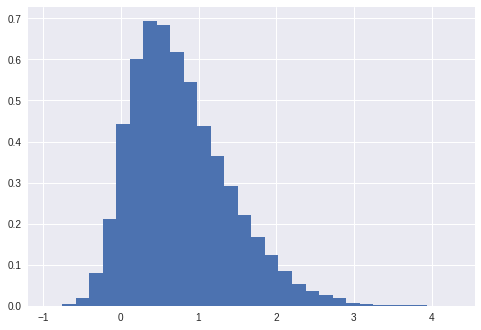

In [501]:
import matplotlib.pyplot as plt
count, bins, ignored = plt.hist(s, 30, normed=True)
plt.show()

In [502]:
from sklearn.preprocessing import scale
standardized_s = scale(s, with_mean=True, with_std=True, copy=True)
standardized_s[:100]

array([-1.29139874, -0.84863308, -0.62989397, -0.1061957 ,  0.64566467,
       -0.84205857,  0.34415123, -0.67342518, -1.29147405, -0.68034857,
        0.3413322 , -1.09002632,  0.21463989, -0.40861412, -0.90802367,
       -1.4639013 , -0.975384  ,  0.83467867,  0.1790082 ,  0.44943504,
       -0.27484756,  0.17239704,  1.20645641,  1.11553127, -0.41490137,
       -0.2128526 ,  0.43627638, -0.28579944, -1.2365559 ,  0.20918854,
       -0.97270831,  0.97638098,  0.23983134,  0.04976587, -0.25444095,
       -0.67795236, -0.4595243 ,  0.55345786, -0.46353969, -0.34487776,
       -0.63065359, -0.95754073,  0.63185971, -0.26928097, -0.49878723,
       -0.23378258,  0.16716758, -0.73585958, -0.1074247 , -0.6963634 ,
       -0.8766546 , -0.72896454,  2.56542761, -1.75641386, -1.46584292,
        0.79699317, -0.80885125, -0.65406455, -0.62749015,  0.33579595,
        2.30023793, -0.57755004,  0.53816347,  0.43443826,  0.87589677,
        1.28140397, -0.48387607,  0.09157976,  0.17851116, -1.23

## Normalization

In [503]:
from sklearn.preprocessing import minmax_scale
norm = minmax_scale(s)
norm[:100]

array([0.16979831, 0.22344579, 0.2499492 , 0.31340284, 0.40450162,
       0.22424239, 0.3679689 , 0.24467477, 0.16978919, 0.2438359 ,
       0.36762733, 0.1941975 , 0.35227672, 0.27676047, 0.21624976,
       0.14889713, 0.20808808, 0.42740341, 0.34795943, 0.38072556,
       0.29296822, 0.34715839, 0.47244967, 0.46143277, 0.27599868,
       0.30047981, 0.3791312 , 0.29164124, 0.17644332, 0.35161621,
       0.20841228, 0.4445727 , 0.35532903, 0.33229985, 0.29544078,
       0.24412623, 0.27059196, 0.39332943, 0.27010544, 0.28448305,
       0.24985717, 0.21025005, 0.40282895, 0.2936427 , 0.26583469,
       0.29794384, 0.34652476, 0.23710994, 0.31325393, 0.24189547,
       0.22005058, 0.23794537, 0.63710873, 0.11345499, 0.14866187,
       0.42283726, 0.22826594, 0.24702059, 0.25024046, 0.36695654,
       0.60497716, 0.25629143, 0.39147629, 0.37890848, 0.43239758,
       0.48153065, 0.26764139, 0.3373662 , 0.3478992 , 0.17695371,
       0.49089103, 0.40147044, 0.30956668, 0.51722143, 0.30385

## Skewed Data - Log Transformations

In [ ]:
for x in np.nditer(s, op_flags=['readwrite']):
  if x <= 0:
    x[...] = 0.0001

In [505]:
s[:100]

array([1.00000000e-04, 2.36493047e-01, 3.74897525e-01, 7.06261173e-01,
       1.18199158e+00, 2.40652987e-01, 9.91212657e-01, 3.47353690e-01,
       1.00000000e-04, 3.42972997e-01, 9.89428949e-01, 8.37544380e-02,
       9.09265949e-01, 5.14909635e-01, 1.98914381e-01, 1.00000000e-04,
       1.56292956e-01, 1.30158786e+00, 8.86720434e-01, 1.05782969e+00,
       5.99548782e-01, 8.82537305e-01, 1.53682566e+00, 1.47929390e+00,
       5.10931455e-01, 6.38775328e-01, 1.04950371e+00, 5.92619112e-01,
       1.00000000e-04, 9.05816672e-01, 1.57985968e-01, 1.39124827e+00,
       9.25205531e-01, 8.04943940e-01, 6.12460815e-01, 3.44489173e-01,
       4.82696840e-01, 1.12364886e+00, 4.80156152e-01, 5.55238035e-01,
       3.74416891e-01, 1.67583069e-01, 1.17325666e+00, 6.03070973e-01,
       4.57853708e-01, 6.25532143e-01, 8.79228426e-01, 3.07849089e-01,
       7.05483536e-01, 3.32839815e-01, 2.18762770e-01, 3.12211839e-01,
       2.39669799e+00, 1.00000000e-04, 1.00000000e-04, 1.27774283e+00,
      

In [ ]:
log_data = np.log(s)

In [507]:
log_data[:100]

array([-9.21034037e+00, -1.44183647e+00, -9.81102558e-01, -3.47770176e-01,
        1.67200798e-01, -1.42439927e+00, -8.82617936e-03, -1.05741174e+00,
       -9.21034037e+00, -1.07010356e+00, -1.06273217e-02, -2.47986612e+00,
       -9.51176542e-02, -6.63763859e-01, -1.61488080e+00, -9.21034037e+00,
       -1.85602311e+00,  2.63584953e-01, -1.20225527e-01,  5.62193492e-02,
       -5.11577937e-01, -1.24954220e-01,  4.29719032e-01,  3.91564877e-01,
       -6.71519836e-01, -4.48202486e-01,  4.83173987e-02, -5.23203392e-01,
       -9.21034037e+00, -9.89183422e-02, -1.84524906e+00,  3.30201377e-01,
       -7.77393703e-02, -2.16982644e-01, -4.90270314e-01, -1.06569262e+00,
       -7.28366483e-01,  1.16581297e-01, -7.33643910e-01, -5.88358366e-01,
       -9.82385422e-01, -1.78627611e+00,  1.59783355e-01, -5.05720389e-01,
       -7.81205560e-01, -4.69152562e-01, -1.28710545e-01, -1.17814559e+00,
       -3.48871845e-01, -1.10009394e+00, -1.51976738e+00, -1.16407335e+00,
        8.74091952e-01, -

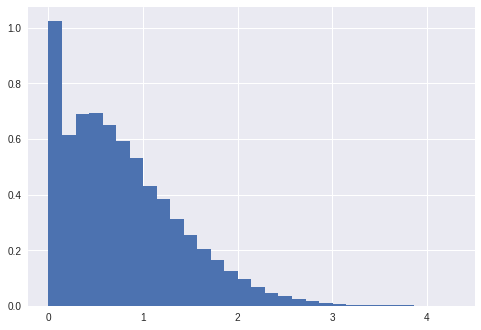

In [509]:
import matplotlib.pyplot as plt
count, bins, ignored = plt.hist(s, 30, normed=True)
plt.show()

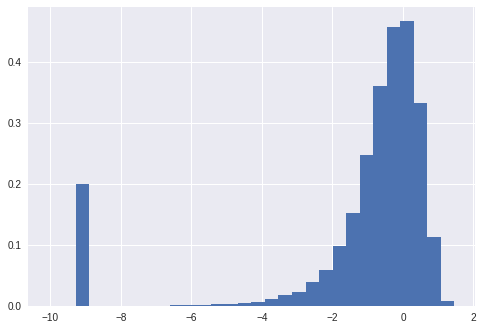

In [508]:
import matplotlib.pyplot as plt
count, bins, ignored = plt.hist(log_data, 30, normed=True)
plt.show()